# 오차역전파(Back propagation)
* 이때까지 신경망의 가중치 매개변수의 기울기(손실함수의 기울기)는 수치 미분을 사용해 계산
* 수치 미분은 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸림(오버헤드가 크다)
* 가중치 매개변수의 기울기를 고속, 효율적으로 계산하는 오차 역전파 방식



## 참고
* MSE(Mean Squared Error)는 회귀 문제에 주로 사용되는 손실함수
* CEE(Cross Entropy Error)는 분류 문제에 주로 사용되는 손실함수
* BCE(Binary Cross Entropy)는 이진분류문제에 주로 사용되는 손실함수

> $E_{MSE}=\frac{1}{n}\Sigma_{k=0}^{k=n-1}(y_k-t_k)^2 $   

> $E_{CEE}=-\frac{1}{N}\Sigma_{n}\Sigma_{k}t_{nk}\log y_{nk} $   

## 순전파(forward propagation)
* 계산을 왼쪽에서 오른쪽으로 순차적으로 진행하는 단계

## 역전파(backward propagation)
* 계산을 오른쪽에서 왼쪽으로 역순으로 진행하는 단계

# 활성화 함수 계층 구현하기(1)
* Relu 계층   

> $y = \begin{cases}x \quad(x > 0)\\0\quad(x \leq 0) \end{cases}$   

> $\frac{\partial{y}}{\partial{x}}=\begin{cases}1 \quad(x > 0)\\0\quad(x \leq 0)\end{cases}$

In [1]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

# 활성화 함수 계층 구현하기(2)
* Sigmoid 계층   

> $y = \frac{1}{1+\exp^{-x}}$

In [3]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab_Notebooks')

class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out
  
  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

Mounted at /content/drive


# 활성화 함수 계층 구현하기(3)
* Affine계층   


In [9]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    return dx
  

# 활성화 함수 계층 구현하기(4)
* Softmax계층   
* 정리: 역전파를 이용한 활성화 함수들의 기울기를 구하여 경사하강법을 통해 가중치 매개변수를 데이터에 맞게 피팅시켜간다.

In [13]:
from sample.common.functions import *

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
  
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx

# 신경망 학습의 전체 그림

* 전제
> 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.
* 1단계 - 미니배치
> 훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표
* 2단계 - 기울기 산출
> 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.
* 3단계 - 매개변수 갱신
> 가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.
* 4단계 - 반복
> 1~3단계를 반복한다. 또한 오차역전파법을 이용하면 느린 수치 미분과 달리 기울기를 효율적이고 빠르게 구할 수 있다.

In [17]:
# 2층 신경망 클래스 구현하기
import matplotlib.pyplot as plt
from sample.common.gradient import numerical_gradient
from collections import OrderedDict

def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]

    # f(x+h) 계산
    x[idx] = tmp_val+h
    fxh1 = f(x)

    # f(x-h) 계산
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp_val

  return grad


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [19]:
import numpy as np
from sample.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# Hyper Parmater
iters_num = 10000 # 가중치를 SGD를 적용하기 위한 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  # 미니배치 획득
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # 오차 역전파법으로 기울기를 구한다
  grad = network.gradient(x_batch, t_batch)

  # 매개변수 갱신
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # 학습 결과 기록
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train acc, test_acc |' + str(train_acc) + ", " + str(test_acc))

train acc, test_acc |0.09928333333333333, 0.1017
train acc, test_acc |0.9039666666666667, 0.9062
train acc, test_acc |0.9259833333333334, 0.9268
train acc, test_acc |0.93705, 0.9384
train acc, test_acc |0.94625, 0.9442
train acc, test_acc |0.9525666666666667, 0.9493
train acc, test_acc |0.9567166666666667, 0.9533
train acc, test_acc |0.9618666666666666, 0.9571
train acc, test_acc |0.9661, 0.9609
train acc, test_acc |0.9674833333333334, 0.9617
train acc, test_acc |0.9695, 0.9637
train acc, test_acc |0.9719, 0.965
train acc, test_acc |0.9739166666666667, 0.9672
train acc, test_acc |0.9741, 0.9677
train acc, test_acc |0.9774333333333334, 0.9686
train acc, test_acc |0.9785, 0.9709
train acc, test_acc |0.97925, 0.9709


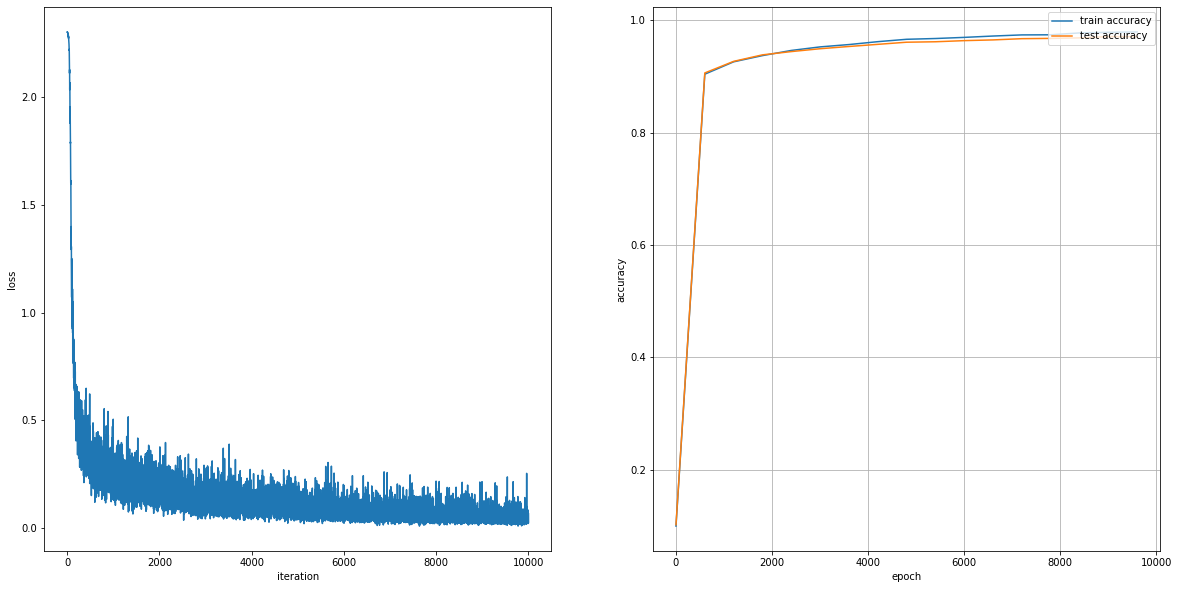

In [28]:
#### plot loss, accuracy ####
iteration = list(range(iters_num))
epoch = list(range(0, iters_num, int(iter_per_epoch)))

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(iteration, train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epoch, train_acc_list, label='train accuracy')
plt.plot(epoch, test_acc_list, label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()